In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import math

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model

2025-08-07 21:22:40.534643: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754601760.738897      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754601760.801709      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preparing Data

In [2]:
data_path='/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
categories = sorted(os.listdir(data_path))

In [3]:
IMG_SIZE=64 
X=[] #images
y=[] #labels

for category in tqdm(categories):
    path= os.path.join(data_path, category)
    for img_name in os.listdir(path):
        img_path=os.path.join(path,img_name)

        img= cv2.imread(img_path)
        img= cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img)
        y.append(category)

100%|██████████| 29/29 [06:43<00:00, 13.91s/it]


# Plotting sample of Data
"It is all of label A because i sort it firs"

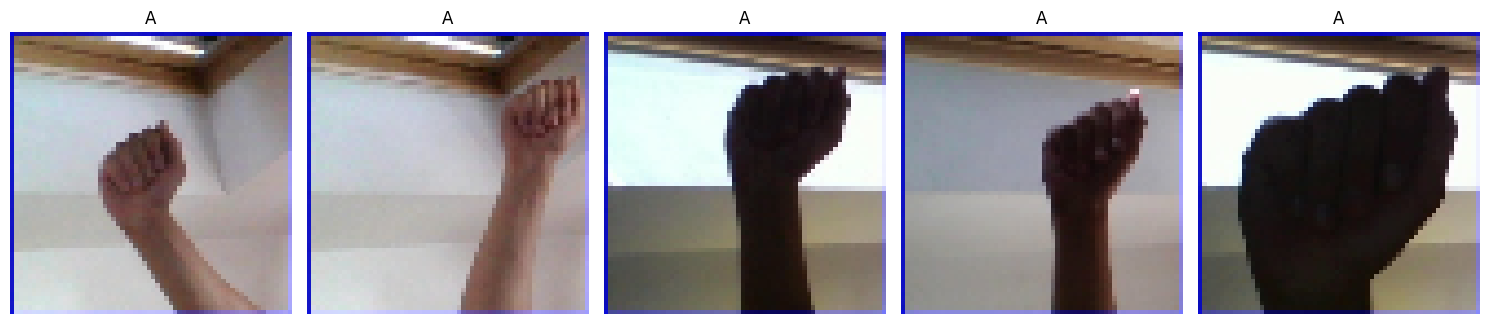

In [4]:
plt.figure(figsize=(15, 5))  

for i in range(5):
    plt.subplot(1, 5, i + 1)  
    plt.imshow(X[i])
    plt.title(y[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


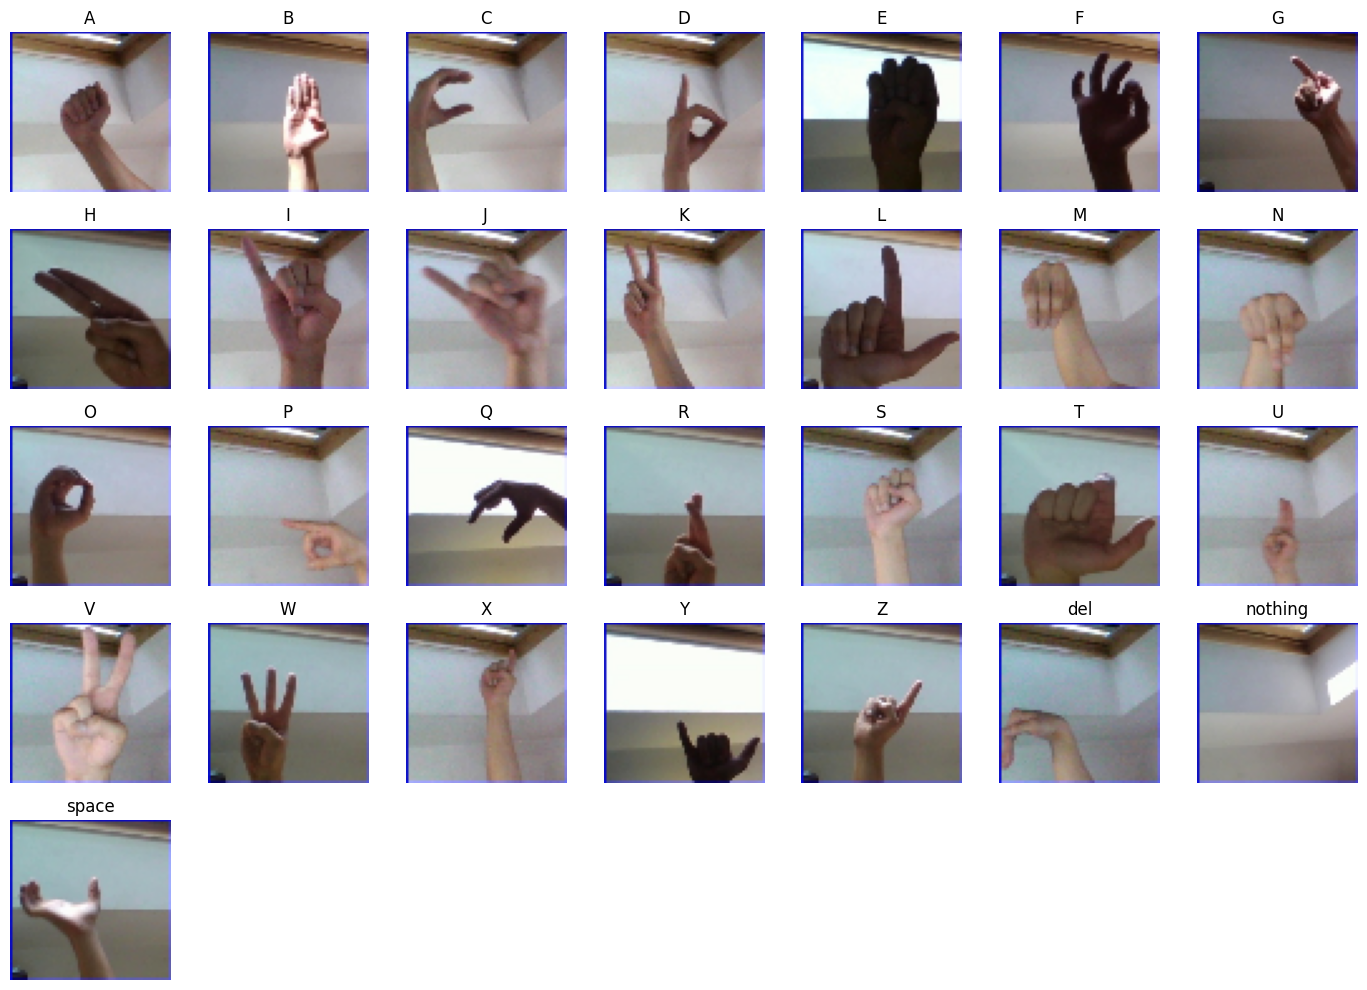

In [5]:
unique_labels = np.unique(y)
shown_labels = set()

num_labels = len(unique_labels)
cols = 7
rows = math.ceil(num_labels / cols)

plt.figure(figsize=(cols * 2, rows * 2))
i = 1

for img, label in zip(X, y):
    if label not in shown_labels:
        plt.subplot(rows, cols, i)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
        shown_labels.add(label)
        i += 1

    if len(shown_labels) == num_labels:
        break

plt.tight_layout()
plt.show()

# Normalizing Data

In [6]:
X=np.array(X)
y=np.array(y)

In [7]:
X=X/255.0

le=LabelEncoder()
y= le.fit_transform(y)
y_cat = to_categorical(y)

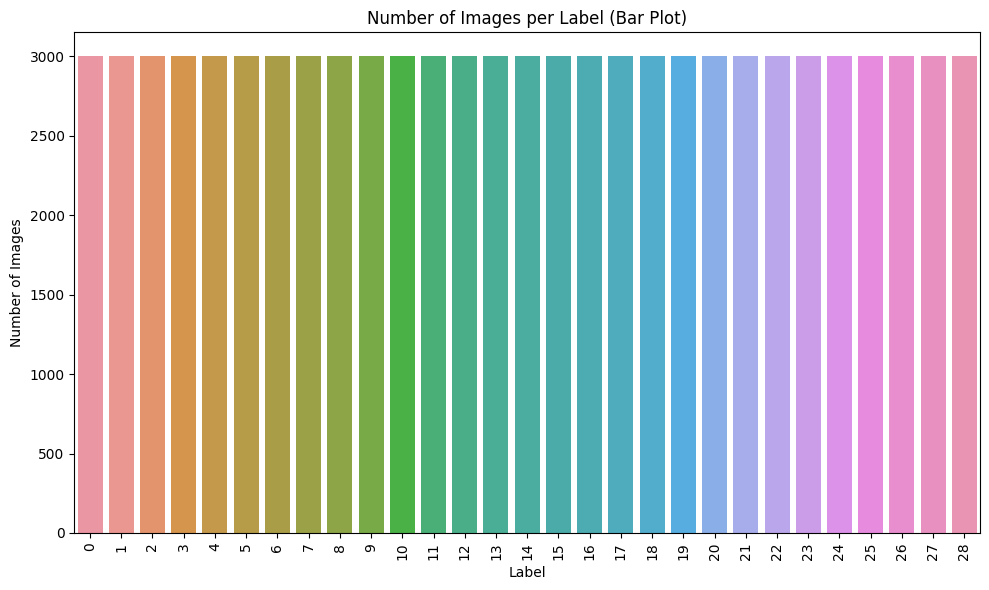

In [8]:
label_counts = pd.Series(y).value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Number of Images per Label (Bar Plot)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

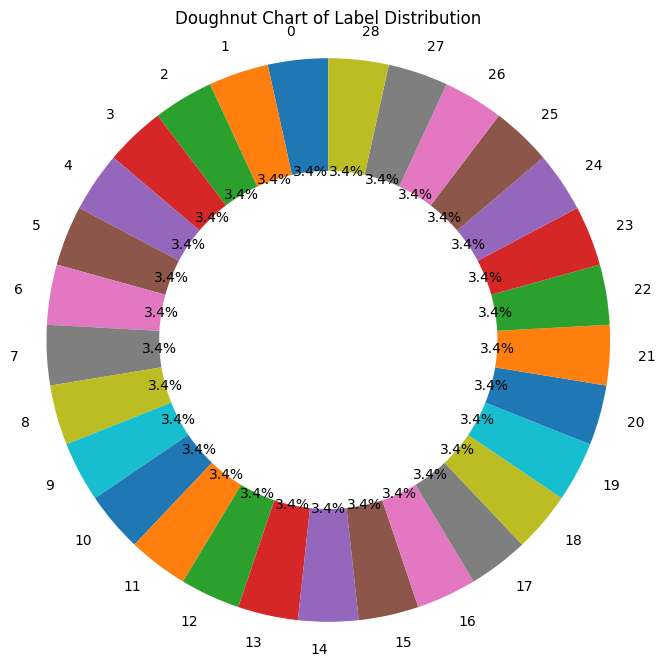

In [9]:
label_counts = pd.Series(y).value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops={'width':0.4})
plt.title('Doughnut Chart of Label Distribution')
plt.axis('equal')
plt.show()

# Splitting Data

In [10]:
X_train, X_test, y_train, y_test =train_test_split(X,y_cat , test_size=0.2 , random_state=42, stratify=y) #to make same presntages in train , tet

# Data Augmentation

In [11]:
datagen=ImageDataGenerator(
    rotation_range=5,
    zoom_range=0.02,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False
)
datagen.fit(X_train)

# CNN Model

In [12]:
model= Sequential()

model.add(Conv2D(32,(3,3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(y_cat.shape[1], activation='softmax')) 


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1754602190.534260      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754602190.534923      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [13]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.build(input_shape=(None, 64, 64, 3)) 
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,869 (2.00 MB)

 Trainable params: 523,613 (2.00 MB)

 Non-trainable params: 256 (1.00 KB)

In [15]:
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

In [16]:
train_generator = datagen.flow(
    X_train,
    y_train, 
    batch_size=32,
    shuffle=True
)

In [17]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr],
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1754602197.121753      65 service.cc:148] XLA service 0x7a9d380040c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754602197.123300      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754602197.123321      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754602197.554238      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


   5/2175 ━━━━━━━━━━━━━━━━━━━━ 1:09 32ms/step - accuracy: 0.0012 - loss: 3.5099   

I0000 00:00:1754602201.048952      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 98s 42ms/step - accuracy: 0.4219 - loss: 2.0002 - val_accuracy: 0.9628 - val_loss: 0.1294 - learning_rate: 0.0010
Epoch 2/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 86s 39ms/step - accuracy: 0.9291 - loss: 0.2313 - val_accuracy: 0.9822 - val_loss: 0.0555 - learning_rate: 0.0010
Epoch 3/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 85s 39ms/step - accuracy: 0.9649 - loss: 0.1165 - val_accuracy: 0.9750 - val_loss: 0.0716 - learning_rate: 0.0010
Epoch 4/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 85s 39ms/step - accuracy: 0.9747 - loss: 0.0832 - val_accuracy: 0.9885 - val_loss: 0.0368 - learning_rate: 0.0010
Epoch 5/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 85s 39ms/step - accuracy: 0.9800 - loss: 0.0622 - val_accuracy: 0.9979 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 6/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - accuracy: 0.9855 - loss: 0.0504 - val_accuracy: 0.9987 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 7/30
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 83s 38ms/step - accuracy: 0.9885 

# Model Evaluation

In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.2962e-04
Test Loss: 0.0001
Test Accuracy: 1.0000


In [19]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true, y_pred_classes)
print(f"\033[1mTest Accuracy: {acc:.4f}\033[0m\n")  

target_names = le.inverse_transform(np.unique(y_true))
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print("\033[1mClassification Report:\033[0m")  
print(report)

544/544 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       600
           B       1.00      1.00      1.00       600
           C       1.00      1.00      1.00       600
           D       1.00      1.00      1.00       600
           E       1.00      1.00      1.00       600
           F       1.00      1.00      1.00       600
           G       1.00      1.00      1.00       600
           H       1.00      1.00      1.00       600
           I       1.00      1.00      1.00       600
           J       1.00      1.00      1.00       600
           K       1.00      1.00      1.00       600
           L       1.00      1.00      1.00       600
           M       1.00      1.00      1.00       600
           N       1.00      1.00      1.00       600
           O       1.00      1.00      1.00       600
           P       1.00      1.00      1.00     

544/544 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


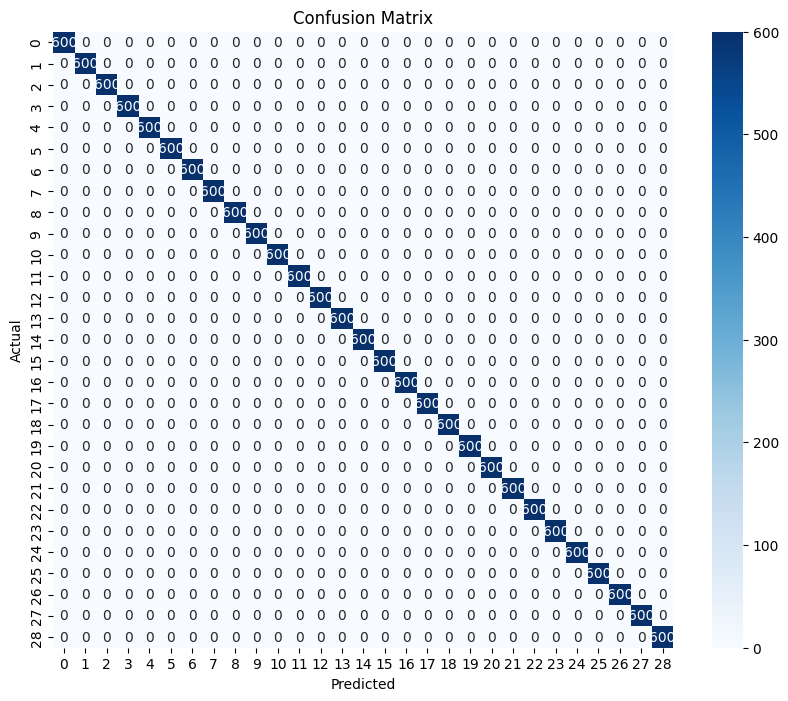

In [20]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Model Saving

In [21]:
save_model(model, 'sign_language_model.h5')